In [1]:
import core.vem as vem
import numpy as np
import matplotlib.pyplot as plt

# Define the load function
def f(c):
    return -np.sin(np.pi*c[0])*np.sin(np.pi*c[1])

# Generate a structured mesh on the unit square
def unit_square_mesh(nx, ny):
    hx = 1.0 / (nx - 1)
    hy = 1.0 / (ny - 1)
    nodes = np.array([[i*hx, j*hy] for j in range(ny) for i in range(nx)])
    elements = []
    for j in range(ny - 1):
        for i in range(nx - 1):
            n0 = i + j*nx
            n1 = n0 + 1
            n2 = n0 + nx
            n3 = n2 + 1
            elements.append([n0, n1, n3])
            elements.append([n0, n3, n2])
    return nodes, np.array(elements)

# Function to get boundary node indices
def get_boundary_nodes(nodes):
    tol = 1e-12
    boundary_indices = np.where((np.abs(nodes[:, 0]) < tol) | (np.abs(nodes[:, 0] - 1) < tol) |
                                (np.abs(nodes[:, 1]) < tol) | (np.abs(nodes[:, 1] - 1) < tol))[0]
    return boundary_indices

# Parameters
nx = 31  # Number of nodes in x direction
ny = 31  # Number of nodes in y direction
nodes, elements = unit_square_mesh(nx, ny)
supp = get_boundary_nodes(nodes)


#################### Poisson #####################
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.00055438 -0.00110204 -0.00163726 -0.00215429
 -0.00264756 -0.00311171 -0.00354167 -0.00393276 -0.00428071 -0.00458173
 -0.00483252 -0.00503033 -0.00517302 -0.00525903 -0.00528741 -0.00525786
 -0.00517071 -0.00502692 -0.00482806 -0.00457633 -0.00427449 -0.00392586
 -0.00353427 -0.00310402 -0.00263985 -0.00214687 -0.00163054 -0.00109659
 -0.00055099  0.          0.         -0.00110204 -0.00219113 -0.0032556
 -0.004284   -0.00526516 -0.0061884  -0.00704368 -0.00782166 -0.00851384
 -0.00911267 -0.00961161 -0.01000519 -0.01028913 -0.01046032 -0.01051689
 -0.01045824 -0.01028501 -0.00999912 -0.

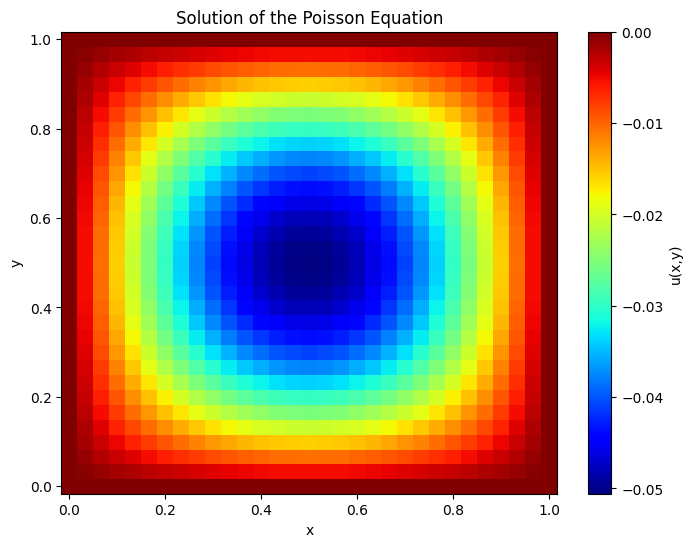

In [2]:
K = vem.buildGlobalPoisson(nodes, elements)
F = vem.buildPoissonLoad(f, nodes, elements)

K, F = vem.applyPoissonDBC(K,F, supp)

print()
print("#################### Poisson #####################")
uh = np.linalg.solve(K,F)
print(uh)
print("####################################################")

# Reshape the solution to fit the mesh
h = int(np.sqrt(len(nodes))) - 1
uh_reshaped = uh.reshape((h+1, h+1))

# Create meshgrid for plotting
X = nodes[:, 0].reshape((h+1, h+1))
Y = nodes[:, 1].reshape((h+1, h+1))

# Plot the results
plt.figure(figsize=(8, 6))
plt.pcolor(X, Y, uh_reshaped, cmap='jet')
plt.colorbar(label='u(x,y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution of the Poisson Equation')
plt.show()


#################### Poisson #####################
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.00055438 -0.00110204 -0.00163726 -0.00215429
 -0.00264756 -0.00311171 -0.00354167 -0.00393276 -0.00428071 -0.00458173
 -0.00483252 -0.00503033 -0.00517302 -0.00525903 -0.00528741 -0.00525786
 -0.00517071 -0.00502692 -0.00482806 -0.00457633 -0.00427449 -0.00392586
 -0.00353427 -0.00310402 -0.00263985 -0.00214687 -0.00163054 -0.00109659
 -0.00055099  0.          0.         -0.00110204 -0.00219113 -0.0032556
 -0.004284   -0.00526516 -0.0061884  -0.00704368 -0.00782166 -0.00851384
 -0.00911267 -0.00961161 -0.01000519 -0.01028913 -0.01046032 -0.01051689
 -0.01045824 -0.01028501 -0.00999912 -0.

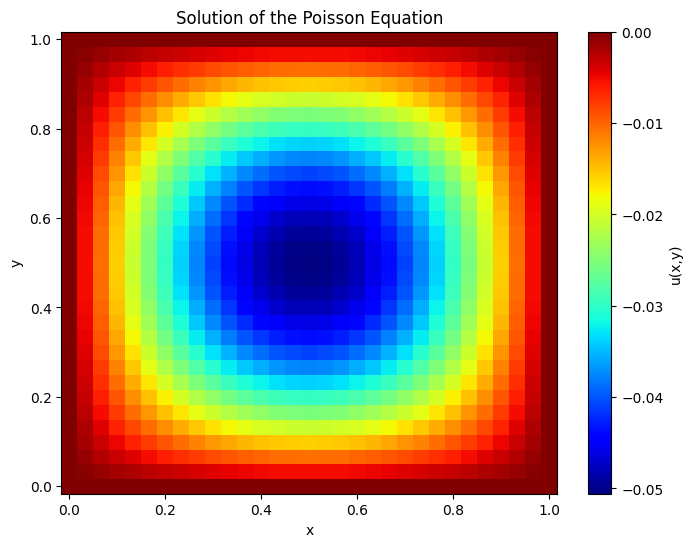

In [3]:
# not using Ks
K = vem.buildGlobalPoisson(nodes, elements, use_stabilization=False)
F = vem.buildPoissonLoad(f, nodes, elements)

K, F = vem.applyPoissonDBC(K,F, supp)

print()
print("#################### Poisson #####################")
uh = np.linalg.solve(K,F)
print(uh)
print("####################################################")

# Reshape the solution to fit the mesh
h = int(np.sqrt(len(nodes))) - 1
uh_reshaped = uh.reshape((h+1, h+1))

# Create meshgrid for plotting
X = nodes[:, 0].reshape((h+1, h+1))
Y = nodes[:, 1].reshape((h+1, h+1))

# Plot the results
plt.figure(figsize=(8, 6))
plt.pcolor(X, Y, uh_reshaped, cmap='jet')
plt.colorbar(label='u(x,y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution of the Poisson Equation')
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

def compute_loss(K, uh, F):
    """
    Compute the loss function as (K * uh - F)^2 using PyTorch

    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh (torch.Tensor): Solution vector (ndof x 1)
    F (torch.Tensor): Load vector (ndof x 1)

    Returns:
    torch.Tensor: The loss value
    """
    # Compute the residual
    R = torch.matmul(K, uh) - F
    
    # Compute the loss (squared residual)
    loss = torch.sum(R**2)
    
    return loss

# Define a neural network to approximate an n x n matrix
class MatrixApproximator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MatrixApproximator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
input_dim = nx * ny  # Input dimension corresponding to each element in the matrix
output_dim = nx * ny  # Output dimension corresponding to each element in the matrix

model = MatrixApproximator(input_dim, output_dim)
loss = compute_loss(torch.tensor(K), torch.tensor(uh), torch.tensor(F))

In [5]:
# geometry data
L = 2.0
nodes = np.array([[0,0],[0,L],[L,L],[L,0]])
elements = np.array([[0,1],[1,2],[2,3]])
supp = np.array([[0,1,1,1], [3,1,1,1]])
I = 36e-4
A = 0.12

# material data
E = 20e6

# loads
load = np.array([[1,2]])
q = -400
t = 0
f_dist = vem.buildBeamDistributedLoad(load,t,q,nodes)

# stiffness matrix
K = vem.buildGlobaBeamK(nodes, elements, E, A, I, 1)

# apply DBC
K, f = vem.applyDBCBeam(K, f_dist, supp)

# solve
print()
print("######################### Beam ##########################")
uh_vem = np.linalg.solve(K,f)
print(uh_vem)
print("#########################################################")

Coords: [[0. 0.]
 [0. 2.]] - Length: 2.0
Coords: [[0. 2.]
 [2. 2.]] - Length: 2.0
Coords: [[2. 2.]
 [2. 0.]] - Length: 2.0

######################### Beam ##########################
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.16360817e-04
 -3.20308731e-04 -8.04745594e-04  5.44061872e-05 -3.46357935e-04
  6.33978590e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00]
#########################################################


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

def compute_loss(K, uh, F):
    """
    Compute the loss function as (K * uh - F)^2 using PyTorch

    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh (torch.Tensor): Solution vector (ndof x 1)
    F (torch.Tensor): Load vector (ndof x 1)

    Returns:
    torch.Tensor: The loss value
    """
    # Compute the residual
    R = torch.matmul(K, uh) - F
    
    # Compute the loss (squared residual)
    loss = torch.sum(R**2)
    
    return loss

def compute_boundary_loss(uh, supp):
    """
    Compute the loss function for enforcing the Dirichlet boundary conditions.

    Parameters:
    uh (torch.Tensor): Solution vector (ndof x 1)
    supp (torch.Tensor): Support vector (ndof x N, where N is the number of nodes with boundary conditions)

    Returns:
    torch.Tensor: The loss value as a PyTorch tensor
    """
    # Initialize the loss as a scalar tensor with zero
    loss = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)
    
    for node in supp:
        if node[1] == 1:  # x-direction fixed
            k = 3 * int(node[0])
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor
        if node[2] == 1:  # y-direction fixed
            k = 3 * int(node[0]) + 1
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor
        if node[3] == 1:  # z-direction fixed
            k = 3 * int(node[0]) + 2
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor

    return loss

# Define neural network for the beam problem
class BeamApproximator(nn.Module):
    def __init__(self, input_dim, ndof):
        super(BeamApproximator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, ndof)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Assuming nodes, K, and f are already defined
ndof = 3 * len(nodes)
input_dim = 2*len(nodes)

nodes = nodes.flatten()
nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

# Initialize the model and optimizer
model = BeamApproximator(input_dim, ndof)
optimizer = optim.Adam(model.parameters(), lr=0.01)

K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
f = torch.tensor(f, dtype=torch.float32, requires_grad=True)

/opt/anaconda3/envs/ml-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
epochs = 4000
for  epoch in range(epochs):
    optimizer.zero_grad()
    uh = model(nodes)
    loss = compute_loss(K, uh, f)
    loss_bc = compute_boundary_loss(uh, supp)
    loss = loss + loss_bc
    loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

Epoch: 1, Loss: 15441063936.0
Epoch: 2, Loss: 4996349296640.0
Epoch: 3, Loss: 443536408576.0
Epoch: 4, Loss: 288048971776.0
Epoch: 5, Loss: 722290802688.0
Epoch: 6, Loss: 598809968640.0
Epoch: 7, Loss: 306254643200.0
Epoch: 8, Loss: 104744058880.0
Epoch: 9, Loss: 16353737728.0
Epoch: 10, Loss: 19564369920.0
Epoch: 11, Loss: 51136655360.0
Epoch: 12, Loss: 70991601664.0
Epoch: 13, Loss: 64044175360.0
Epoch: 14, Loss: 42740228096.0
Epoch: 15, Loss: 21337194496.0
Epoch: 16, Loss: 6741496832.0
Epoch: 17, Loss: 1703984896.0
Epoch: 18, Loss: 4930219008.0
Epoch: 19, Loss: 11705444352.0
Epoch: 20, Loss: 15514546176.0
Epoch: 21, Loss: 14486001664.0
Epoch: 22, Loss: 10416304128.0
Epoch: 23, Loss: 5956329984.0
Epoch: 24, Loss: 2724225024.0
Epoch: 25, Loss: 1251292800.0
Epoch: 26, Loss: 1222169088.0
Epoch: 27, Loss: 1981615104.0
Epoch: 28, Loss: 2919080704.0
Epoch: 29, Loss: 3625094144.0
Epoch: 30, Loss: 3906451456.0
Epoch: 31, Loss: 3781089280.0
Epoch: 32, Loss: 3359515904.0
Epoch: 33, Loss: 27895

In [8]:
uh

tensor([-5.6606e-05, -5.9118e-05,  2.8741e-05, -7.3392e-05, -3.7213e-04,
        -7.2907e-04, -1.4291e-04, -2.7205e-04,  6.2144e-04, -1.5937e-05,
         5.9401e-05,  3.6576e-05], grad_fn=<ViewBackward0>)

In [9]:
# Set the model to evaluation mode
model.eval()

# Ensure gradients are not tracked during prediction
with torch.no_grad():
    # Use the trained model to make predictions
    predicted_displacements = model(nodes)

# Print or use the predicted displacements
print("Predicted displacements:", predicted_displacements)

Predicted displacements: tensor([ 5.9815e-05,  3.3712e-05, -7.4282e-06,  5.8558e-05, -2.8252e-04,
        -7.1716e-04, -2.2288e-05, -3.8822e-04,  6.9938e-04,  2.9892e-05,
        -6.9027e-05, -4.4752e-05])


In [10]:
def compute_l2_error(uh_vem, uh_nn):
    """
    Compute the L2 norm error between the FEM and NN displacement fields.

    Parameters:
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: L2 norm error as a scalar
    """
    error = torch.norm(uh_nn - uh_vem) / torch.norm(uh_vem)
    return error

In [11]:
compute_l2_error(torch.tensor(uh_vem), predicted_displacements)

tensor(0.1690, dtype=torch.float64)

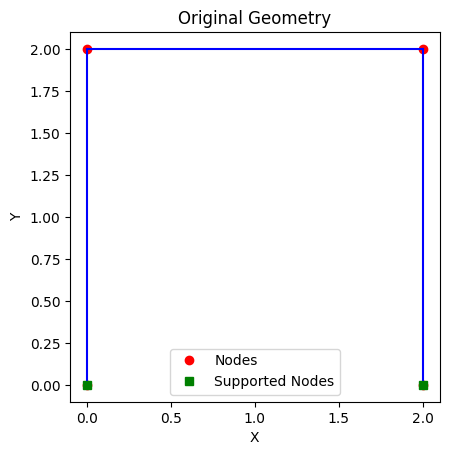

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Geometry data
L = 2.0
nodes = np.array([[0,0],[0,L],[L,L],[L,0]])
elements = np.array([[0,1],[1,2],[2,3]])
supp = np.array([[0,1,1,1], [3,1,1,1]])

# Function to plot the original geometry
def plot_geometry(nodes, elements, supp):
    fig, ax = plt.subplots()
    
    # Plot nodes
    ax.plot(nodes[:, 0], nodes[:, 1], 'ro', label='Nodes')
    
    # Plot elements as lines connecting nodes
    for element in elements:
        element_coords = nodes[element]
        ax.plot(element_coords[:, 0], element_coords[:, 1], 'b-')
    
    # Highlight supported nodes
    for node in supp[:, 0]:
        ax.plot(nodes[node, 0], nodes[node, 1], 'gs', label='Supported Nodes' if node == supp[0, 0] else "")
    
    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Original Geometry')
    plt.legend()
    plt.show()

# Plot the original geometry
plot_geometry(nodes, elements, supp)

In [13]:
num_elements_per_edge = 2

x_coords = np.linspace(0, L, num_elements_per_edge + 1)
y_coords = np.linspace(0, L, num_elements_per_edge + 1)

top_nodes = np.array([[x, L] for x in x_coords if x != 0])
left_nodes = np.array([[0, y] for y in y_coords])
right_nodes = np.array([[L, y] for y in reversed(y_coords) if y != L])

nodes = np.vstack([left_nodes, top_nodes, right_nodes])

elements = np.array([[i, i+1] for i in range(len(nodes)-len(top_nodes)+1)])
flatten_elements = elements.flatten()

supp = np.array([[flatten_elements[0], 1, 1, 1], [flatten_elements[-1], 1, 1, 1]])

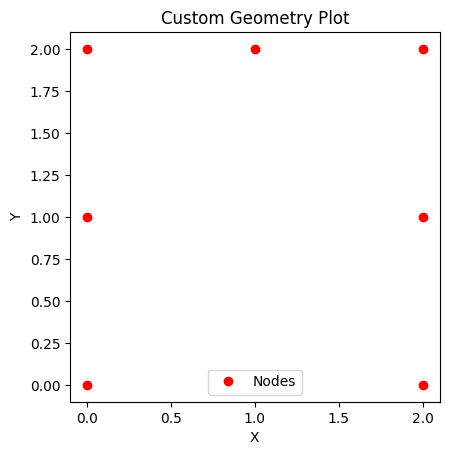

In [14]:
def plot_nodes(nodes):
    fig, ax = plt.subplots()
    
    # Plot nodes
    ax.plot(nodes[:, 0], nodes[:, 1], 'ro', label='Nodes')

    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Custom Geometry Plot')
    plt.legend()
    plt.show()

# Plot the nodes
plot_nodes(nodes)

In [15]:
elements

array([[0, 1],
       [1, 2],
       [2, 3],
       [3, 4],
       [4, 5],
       [5, 6]])

In [16]:
nodes

array([[0., 0.],
       [0., 1.],
       [0., 2.],
       [1., 2.],
       [2., 2.],
       [2., 1.],
       [2., 0.]])

In [17]:
# geometry data
L = 2.0
I = 36e-4
A = 0.12

# material data
E = 20e6

# loads
load = np.array([[2,3],[3,4]])
q = -400
t = 0
f_dist = vem.buildBeamDistributedLoad(load,t,q,nodes)

# stiffness matrix
K = vem.buildGlobaBeamK(nodes, elements, E, A, I, 1)

# apply DBC
K, f = vem.applyDBCBeam(K, f_dist, supp)

# solve
print()
print("######################### Beam ##########################")
uh_vem = np.linalg.solve(K,f)
print(uh_vem)
print("#########################################################")

Coords: [[0. 0.]
 [0. 1.]] - Length: 1.0
Coords: [[0. 1.]
 [0. 2.]] - Length: 1.0
Coords: [[0. 2.]
 [1. 2.]] - Length: 1.0
Coords: [[1. 2.]
 [2. 2.]] - Length: 1.0
Coords: [[2. 2.]
 [2. 1.]] - Length: 1.0
Coords: [[2. 1.]
 [2. 0.]] - Length: 1.0

######################### Beam ##########################
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.44133539e-04
 -1.66666667e-04  1.37341906e-04  2.71665308e-05 -3.33333333e-04
 -6.30867216e-04 -9.29349757e-20 -8.80248423e-04 -9.60632642e-21
 -2.71665308e-05 -3.33333333e-04  6.30867216e-04  1.44133539e-04
 -1.66666667e-04 -1.37341906e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
#########################################################


In [18]:
# Define neural network for the beam problem
class BeamApproximator(nn.Module):
    def __init__(self, input_dim, layers, ndof):
        super(BeamApproximator, self).__init__()
        # First layer from input to the first hidden layer
        self.fin = nn.Linear(input_dim, layers[0])
        
        # Hidden layers
        self.hidden = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # Final output layer from the last hidden layer to the output (ndof)
        self.fout = nn.Linear(layers[-1], ndof)

    def forward(self, x):
        # Pass through the first layer
        z = torch.relu(self.fin(x))
        
        # Pass through the hidden layers
        for layer in self.hidden:
            z = torch.relu(layer(z))
        
        # Final output layer
        z = self.fout(z)
        
        return z

# Assuming nodes, K, and f are already defined
ndof = 3 * len(nodes)
input_dim = 2*len(nodes)

nodes = nodes.flatten()
nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

# Initialize the model and optimizer
layers = [128, 128, 256, 512, 512]
model = BeamApproximator(input_dim, layers, ndof)
optimizer = optim.Adam(model.parameters(), lr=0.01)

K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
f = torch.tensor(f, dtype=torch.float32, requires_grad=True)

In [19]:
epochs = 40000
for  epoch in range(epochs):
    optimizer.zero_grad()
    uh = model(nodes)
    loss = compute_loss(K, uh, f)
    loss_bc = compute_boundary_loss(uh, supp)
    loss = loss + loss_bc
    loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

Epoch: 1, Loss: 146965626880.0
Epoch: 2, Loss: 493702397034496.0
Epoch: 3, Loss: 250722549760.0
Epoch: 4, Loss: 310204530688.0
Epoch: 5, Loss: 55231791104.0
Epoch: 6, Loss: 507518517248.0
Epoch: 7, Loss: 215384145920.0
Epoch: 8, Loss: 131343245312.0
Epoch: 9, Loss: 237878132736.0
Epoch: 10, Loss: 78555152384.0
Epoch: 11, Loss: 53084794880.0
Epoch: 12, Loss: 29151508480.0
Epoch: 13, Loss: 78321999872.0
Epoch: 14, Loss: 50961391616.0
Epoch: 15, Loss: 34091993088.0
Epoch: 16, Loss: 7755280896.0
Epoch: 17, Loss: 11109271552.0
Epoch: 18, Loss: 15940298752.0
Epoch: 19, Loss: 19437654016.0
Epoch: 20, Loss: 12190984192.0
Epoch: 21, Loss: 4823170048.0
Epoch: 22, Loss: 1871927936.0
Epoch: 23, Loss: 5195774976.0
Epoch: 24, Loss: 7712728576.0
Epoch: 25, Loss: 6330069504.0
Epoch: 26, Loss: 4060341248.0
Epoch: 27, Loss: 1589762944.0
Epoch: 28, Loss: 1317577728.0
Epoch: 29, Loss: 1308327168.0
Epoch: 30, Loss: 2201453312.0
Epoch: 31, Loss: 2539652352.0
Epoch: 32, Loss: 2076150656.0
Epoch: 33, Loss: 14

In [26]:
def compute_energy_error(K, uh_fem, uh_nn):
    """
    Compute the energy error between the FEM and NN solutions.

    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: Energy error as a scalar
    """
    # Ensure all tensors are of the same type (float32)
    K = K.float()
    uh_fem = uh_fem.float()
    uh_nn = uh_nn.float()
    
    # Compute strain energy for FEM and NN solutions
    U_fem = 0.5 * torch.matmul(uh_fem.T, torch.matmul(K, uh_fem))
    U_nn = 0.5 * torch.matmul(uh_nn.T, torch.matmul(K, uh_nn))

    # Compute energy error
    energy_error = (U_nn - U_fem) / U_fem
    return energy_error.abs()  # Return the absolute value of the error

import torch

def compute_h1_norm(K, uh_fem, uh_nn):
    """
    Compute the H1 norm between the FEM and NN solutions.
    
    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: H1 norm error as a scalar
    """
    # Ensure all tensors are of the same type and have requires_grad=True
    uh_fem = uh_fem.float().requires_grad_(True)
    uh_nn = uh_nn.float().requires_grad_(True)

    # Compute L2 norm of the displacement field
    l2_error = torch.norm(uh_nn - uh_fem) ** 2

    # Compute gradient (strain) of the displacement fields
    grad_uh_fem = torch.autograd.grad(uh_fem.sum(), uh_fem, create_graph=True)[0]
    grad_uh_nn = torch.autograd.grad(uh_nn.sum(), uh_nn, create_graph=True)[0]

    # Compute L2 norm of the gradient (strain)
    grad_error = torch.norm(grad_uh_nn - grad_uh_fem) ** 2

    # Combine L2 norm of the displacement and gradient
    h1_error = torch.sqrt(l2_error + grad_error)

    return h1_error

In [27]:
# Set the model to evaluation mode
model.eval()

# Ensure gradients are not tracked during prediction
with torch.no_grad():
    # Use the trained model to make predictions
    predicted_displacements = model(nodes)

# Print or use the predicted displacements
print("Predicted displacements:", predicted_displacements)

l2_error = compute_l2_error(torch.tensor(uh_vem), predicted_displacements).item()
energy_error = compute_energy_error(K, torch.tensor(uh_vem), predicted_displacements).item()
h1_error = compute_h1_norm(K, torch.tensor(uh_vem), predicted_displacements).item()

print(f"L2 error: {l2_error}")
print(f"Energy error: {energy_error}")
print(f"H1 error: {h1_error}")

Predicted displacements: tensor([ 1.1097e-04,  6.5325e-12,  2.6407e-10, -1.2368e-04, -1.5592e-04,
         1.1681e-04,  6.5701e-06, -3.4375e-04, -6.4767e-04,  2.0628e-05,
        -8.8128e-04, -2.3968e-05, -4.7784e-05, -3.2100e-04,  6.1311e-04,
         1.6467e-04, -1.7936e-04, -1.5794e-04, -1.0777e-04,  2.6661e-11,
        -4.9282e-11])
L2 error: 0.12175474553686703
Energy error: 0.03725295141339302
H1 error: 0.00016911872080527246
